In [5]:
import pandas as pd
import numpy as np

In [6]:
orders = pd.read_csv('/Users/mr.tian/Desktop/olist_orders_dataset.csv')
customers = pd.read_csv('/Users/mr.tian/Desktop/olist_customers_dataset.csv')
order_items = pd.read_csv('/Users/mr.tian/Desktop/olist_order_items_dataset.csv')

### Process for cleaning Orders Table

In [7]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


#### Simply clean Orders Table, delete unnecessary null values

In [8]:
# Keep only delivered orders, because the target variable is delivery delay.
# Only delivered orders have meaningful delivery outcome information.
orders = orders[orders['order_status'] == 'delivered']

In [9]:
# Remove records with missing actual delivery date,
# since delay cannot be determined without this information.
orders = orders[orders['order_delivered_customer_date'].notna()]

In [10]:
# Remove records with missing order approval timestamp,
# as they do not provide reliable order processing information.
orders = orders[orders['order_approved_at'].notna()]

In [11]:
# Similarly, remove records with missing carrier delivery date,
# because they lack key logistics timeline information.
orders = orders[orders['order_delivered_carrier_date'].notna()]

#### Change all time column from object to datetime

In [12]:
# Convert all time-related columns from object type to datetime

col = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]
for c in col:
    orders[c] = pd.to_datetime(orders[c])

In [13]:
# Create target variable indicating whether the order was delayed.
# An order is considered delayed if the actual delivery date is later
# than the estimated delivery date.
orders['is_delayed'] = orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']

In [14]:
# Convert the boolean target variable into a binary numeric format (0/1)
orders = pd.get_dummies(orders, columns=['is_delayed'], drop_first=True, dtype=int)

In [15]:
# Rename the generated dummy column to a clearer target variable name
orders = orders.rename(columns={'is_delayed_True': 'is_delayed'})

In [16]:
# Keep only relevant columns to avoid potential data leakage
orders_new = orders[['order_id', 'customer_id', 'order_purchase_timestamp', 'is_delayed']]

In [17]:
orders_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96455 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  96455 non-null  object        
 1   customer_id               96455 non-null  object        
 2   order_purchase_timestamp  96455 non-null  datetime64[ns]
 3   is_delayed                96455 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.7+ MB


### Process for Customers table cleaning

In [18]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [19]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


### Process for Order_items table cleaning

In [20]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [21]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [22]:
# Change to datetime
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'])

In [23]:
oi_new = order_items.groupby('order_id').agg(
            total_price=('price', 'sum'), 
            freight_total=('freight_value', 'sum'), 
            item_count=('order_item_id', 'count'),
            seller_count=('seller_id', 'nunique'),
            avg_price=('price', 'mean')
        )

In [24]:
oi_new.head()

,total_price,freight_total,item_count,seller_count,avg_price
order_id,,,,,
00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1,1,58.90
00018f77f2f0320c557190d7a144bdd3,239.90,19.93,1,1,239.90
000229ec398224ef6ca0657da4fc703e,199.00,17.87,1,1,199.00
00024acbcdf0a6daa1e931b038114c75,12.99,12.79,1,1,12.99
00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1,1,199.90


In [25]:
oi_new.describe()

,total_price,freight_total,item_count,seller_count,avg_price
count,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000
mean,137.754076,22.823562,1.141731,1.013622,125.919255
std,210.645145,21.650909,0.538452,0.122297,190.985636
min,0.850000,0.000000,1.000000,1.000000,0.850000
25%,45.900000,13.850000,1.000000,1.000000,41.990000
50%,86.900000,17.170000,1.000000,1.000000,79.000000
75%,149.900000,24.040000,1.000000,1.000000,139.900000
max,13440.000000,1794.960000,21.000000,5.000000,6735.000000


### Merge Table Part
### 1. Merge orders_new table to oi_new table

In [26]:
orders_new.head()

,order_id,customer_id,order_purchase_timestamp,is_delayed
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,0


In [27]:
df = pd.merge(orders_new, oi_new, how='left', on='order_id')

### 2. Merge Customers table to the df table we just created

In [28]:
df_new = pd.merge(df, customers, how='left', on='customer_id')

In [29]:
df_new.head()

,order_id,customer_id,order_purchase_timestamp,is_delayed,total_price,freight_total,item_count,seller_count,avg_price,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,0,29.99,8.72,1,1,29.99,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,0,118.70,22.76,1,1,118.70,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,0,159.90,19.22,1,1,159.90,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,0,45.00,27.20,1,1,45.00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,0,19.90,8.72,1,1,19.90,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


### Clean the final dateset

In [30]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96455 entries, 0 to 96454
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  96455 non-null  object        
 1   customer_id               96455 non-null  object        
 2   order_purchase_timestamp  96455 non-null  datetime64[ns]
 3   is_delayed                96455 non-null  int64         
 4   total_price               96455 non-null  float64       
 5   freight_total             96455 non-null  float64       
 6   item_count                96455 non-null  int64         
 7   seller_count              96455 non-null  int64         
 8   avg_price                 96455 non-null  float64       
 9   customer_unique_id        96455 non-null  object        
 10  customer_zip_code_prefix  96455 non-null  int64         
 11  customer_city             96455 non-null  object        
 12  customer_state    

In [31]:
for col in df_new.columns:
    print(df_new[col].name, df_new[col].nunique())

order_id 96455
customer_id 96455
order_purchase_timestamp 95933
is_delayed 2
total_price 7636
freight_total 7877
item_count 17
seller_count 5
avg_price 7009
customer_unique_id 93336
customer_zip_code_prefix 14889
customer_city 4085
customer_state 27


In [32]:
# Drop identifier columns that do not provide predictive value
df_new.drop(columns=['order_id', 'customer_id', 'customer_unique_id', 'customer_city', 'customer_zip_code_prefix'], inplace=True)

In [33]:
# Extract time-based features from the purchase timestamp:
# hour of day, weekday, month, and whether the order was placed on a weekend
df_new['order_hour'] = df_new['order_purchase_timestamp'].dt.hour
df_new['order_weekday'] = df_new['order_purchase_timestamp'].dt.weekday
df_new['order_month'] = df_new['order_purchase_timestamp'].dt.month
df_new['is_weekend'] = df_new['order_weekday'].isin([5,6]).astype(int)

In [34]:
# Drop the original timestamp column after feature extraction
df_new.drop(columns=['order_purchase_timestamp'], inplace=True)

In [35]:
# Apply one-hot encoding to the customer_state feature
df_new = pd.get_dummies(df_new, columns=['customer_state'], drop_first=True, dtype=int)

### Dataset preprocessing completed, start model training

In [37]:
# Separate features (X) and target variable (y)
# The model aims to predict whether an order will be delayed
X = df_new.drop(columns=['is_delayed'], axis=1)
y = df_new['is_delayed']

In [38]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Apply scaling to continuous features to prevent numerical instability

from sklearn.compose import ColumnTransformer

continuous_cols = [
    'total_price',
    'freight_total',
    'avg_price',
    'item_count',
    'seller_count'
]

time_cols = [
    'order_hour',
    'order_weekday',
    'order_month'
]

binary_cols = [
    'is_weekend'
]

state_cols = [c for c in X.columns if c.startswith('customer_state_')]

preprocess = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_cols),
        ('time', 'passthrough', time_cols),
        ('binary', 'passthrough', binary_cols),
        ('state', 'passthrough', state_cols),
    ],
    remainder='drop'
)

In [43]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'Logistic': Pipeline([
        ('preprocess', preprocess),
        ('clf', LogisticRegression(max_iter=5000, class_weight='balanced', solver='saga', C=0.1, n_jobs=-1, random_state=42))
    ]),
    'RandomForest': RandomForestClassifier(
                        n_estimators=600,
                        max_depth=12,
                        min_samples_leaf=10,
                        min_samples_split=20,
                        class_weight='balanced_subsample',
                        random_state=42,
                        n_jobs=-1
                    )
}

thresholds = {
    "Logistic": 0.45,       
    "RandomForest": 0.4   
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]

    t = thresholds[name]
    y_pred = (y_prob >= t).astype(int)

    print(
        f"{name} (t={t}):",
        f"acc={accuracy_score(y_test, y_pred):.4f},",
        f"prec={precision_score(y_test, y_pred):.4f},",
        f"rec={recall_score(y_test, y_pred):.4f},",
        f"f1={f1_score(y_test, y_pred):.4f}"
    )

Logistic (t=0.45): acc=0.5824, prec=0.1117, rec=0.6084, f1=0.1887
RandomForest (t=0.4): acc=0.5243, prec=0.1207, rec=0.7890, f1=0.2094


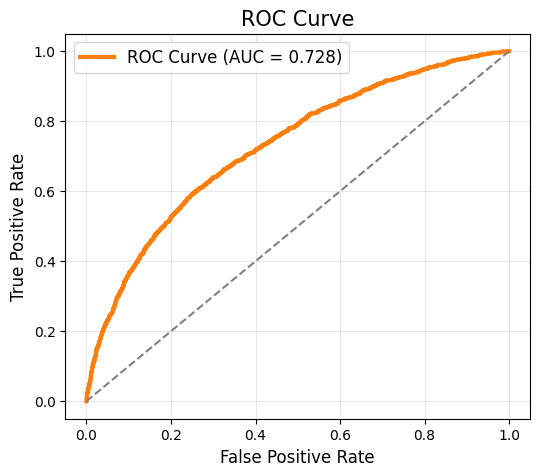

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_score = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='#FF7F0E', linewidth=3,
         label=f'ROC Curve (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.savefig("roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()

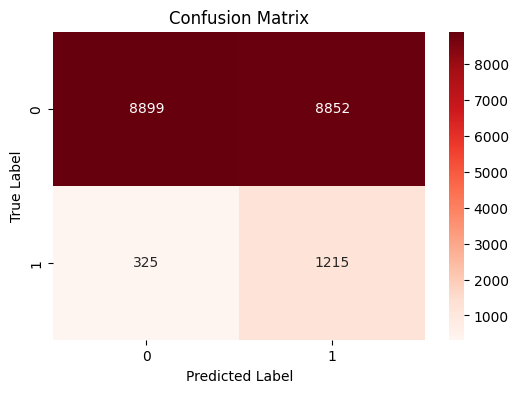

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

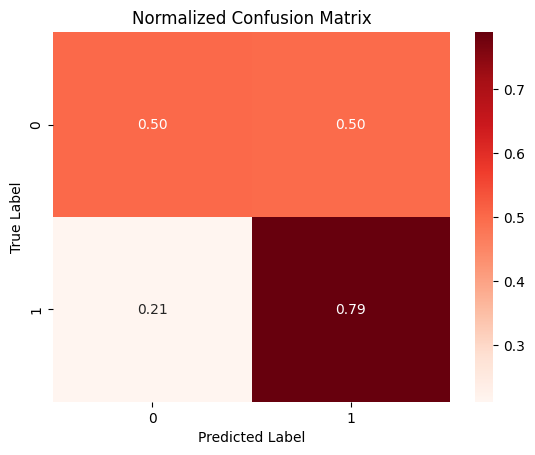

In [55]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()
